# Trabajo Covid version 2

En base a la practica del COVID vacunacion , realizar el proceso de interrupcion en base a que el 5% de los pacientes que estan en la sala de espera presentan complicaciones de salud y deben ser trasladados inmediatamente al centro de salud mas cercano y ser atendidos. Realizar este proceso y generar una segunda linea de simulacion para el traslado , atencion , y alta del paciente que presenta complicaciones , en base a los siguientes datos: 

* Traslado de la ambulacia: 5 - 15 minutos 
* Atencion centro de salud: 5-24 horas
* Alta: 1-2 horas
* el 10% de las personas que presentan complicaciones fallecen 

Generar graficas que indiquen las personas que presentaron complicaciones en base a los tiempos, estado de las personas y respuestas.

In [1]:
# Importamos librerias necesarias
import simpy 
import random 
import numpy as np

In [2]:
TIEMPO_POST_VACUNA = 20
MESAS = 10

CONTROL_SIGNOS = 1
SEMANAS = 2
TIEMPO_VACUNACION = 5
TIEMPO_SIMULACION = SEMANAS * 3 * 9 * 60 # Tiempo simulacion 3 dias a la semana 9 horias diarias

# Guardaremos en las siguientes variables los resultados

In [3]:
cont={0:1}
personas_complicaciones=[]
personas_muertas=[]
personas_altas=[]
personas_total=[]
tiempo_vacunacion={}

# Desarrollo

In [4]:
class Vacunacion():
    def __init__(self, env, nombre, recinto):
        self.env = env
        self.nombre = nombre
        self.complicacion = False
        self.control = False
        self.personas_vacunadas = 0
        self.personas = 0
        self.proceso = env.process(self.proceso_vacunar(recinto))
        env.process(self.complicacion_persona())
        
    def control_signos(self):
        yield self.env.timeout(random.randint(CONTROL_SIGNOS, CONTROL_SIGNOS+2))
    
    def logs_procesos(self,icon,nombre, accion, hora):
        print(" %s nombre: [%s] accion:  [%s] hora:  [%d] "%(icon,nombre, accion, hora))
    
    def aplicar_vacuna(self):
        yield self.env.timeout(random.randint(TIEMPO_VACUNACION, TIEMPO_VACUNACION+5))
        
    def post_vacuna(self, tiempo):
        yield self.env.timeout(tiempo)
        
    
    def proceso_vacunar(self, recinto):
        while True:
            try:
                nombre= 'persona '+str(cont[0])
                cont[0]=cont[0]+1
                personas_total.append(nombre)
                self.logs_procesos("--->",nombre," llega al recinto",self.env.now)
                yield env.process(self.control_signos())
                if random.randint(1,100) > 10:
                    self.logs_procesos("", nombre, "pasa el control", env.now)
                    inicio_vacunacion =  self.env.now
                    yield env.process(self.aplicar_vacuna())
                    tiempo_vacunacion[nombre] = self.env.now - inicio_vacunacion
                    self.logs_procesos("", nombre, "fue vacunada ", self.env.now)
                
                    tiempo_post_vacuna = TIEMPO_POST_VACUNA
                    inicio = self.env.now
                    self.control = True
                    yield env.process(self.post_vacuna(tiempo_post_vacuna))
                    tiempo_post_vacuna = 0
                    self.logs_procesos("", nombre, "sin complicaciones", self.env.now)
                    self.personas_vacunadas += 1
                else:
                    self.logs_procesos("", nombre,"no pasa el control", self.env.now)
            except simpy.Interrupt:
                self.complicacion = True
                self.logs_procesos("", nombre,"presenta complicaciones", self.env.now)
                tiempo_post_vacuna -= self.env.now - inicio
                personas_complicaciones.append(nombre)
                with recinto.request(priority=1) as requerimiento:
                    yield requerimiento
                    env.process(self.proceso_traslado(nombre))
                        
                self.complicacion = False
    
    def complicacion_persona(self):
        while True:
            yield self.env.timeout(25)
            if random.randint(1,100) <=5:
                if not self.complicacion:
                    self.proceso.interrupt()
    
    def proceso_traslado(self, nombre):
        self.logs_procesos(' ', nombre,' se trasladada en ambulancia ',self.env.now)
        
        yield self.env.timeout(random.randint(5,15)) # tiempo traslado en ambulancia 
        self.logs_procesos('', nombre,' es atendido', self.env.now)
        yield self.env.timeout(random.randint(300,1200)) # tiempo en ser atendido 5-24 horas 
        
        if random.randint(1,100) <=10:
            self.logs_procesos('',nombre,' ha fallecido', self.env.now)
            personas_muertas.append(nombre)
        else:
            yield self.env.timeout(random.randint(60,120)) # tiempo en dar alta 1-2 horas
            self.logs_procesos('<---', nombre,'recibe el alta', self.env.now)
            personas_altas.append(nombre)

In [5]:
# Ejecutando la simulacion

env = simpy.Environment()
recinto = simpy.PreemptiveResource(env, capacity=1)
vacunacion = [Vacunacion(env,"Mesa %d"% i, recinto) for i in range(MESAS)]
env.run(until=TIEMPO_SIMULACION)
print("Simulacion realizada despues de %d semanas"%SEMANAS)
for i in vacunacion:
    print("[%s] ha vacunado a [%d] personas"%(i.nombre,i.personas_vacunadas))

 ---> nombre: [persona 1] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 2] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 3] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 4] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 5] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 6] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 7] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 8] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 9] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 10] accion:  [ llega al recinto] hora:  [0] 
  nombre: [persona 1] accion:  [pasa el control] hora:  [1] 
  nombre: [persona 2] accion:  [pasa el control] hora:  [1] 
  nombre: [persona 3] accion:  [pasa el control] hora:  [1] 
  nombre: [persona 4] accion:  [pasa el control] hora:  [1] 
  nombre: [persona 5] accion:  [pasa el control] hora:  [1] 
  nombre: [persona 10] a

  nombre: [persona 871] accion:  [pasa el control] hora:  [2293] 
  nombre: [persona 869] accion:  [fue vacunada ] hora:  [2296] 
  nombre: [persona 862] accion:  [sin complicaciones] hora:  [2298] 
 ---> nombre: [persona 872] accion:  [ llega al recinto] hora:  [2298] 
  nombre: [persona 863] accion:  [sin complicaciones] hora:  [2299] 
 ---> nombre: [persona 873] accion:  [ llega al recinto] hora:  [2299] 
  nombre: [persona 872] accion:  [pasa el control] hora:  [2299] 
  nombre: [persona 870] accion:  [fue vacunada ] hora:  [2301] 
  nombre: [persona 873] accion:  [pasa el control] hora:  [2301] 
  nombre: [persona 871] accion:  [fue vacunada ] hora:  [2303] 
  nombre: [persona 864] accion:  [sin complicaciones] hora:  [2304] 
 ---> nombre: [persona 874] accion:  [ llega al recinto] hora:  [2304] 
  nombre: [persona 872] accion:  [fue vacunada ] hora:  [2305] 
  nombre: [persona 865] accion:  [sin complicaciones] hora:  [2307] 
 ---> nombre: [persona 875] accion:  [ llega al recint

# Obtenemos los siguientes resultados 

In [7]:
print('*'*70,'\n Total de personas: ', len(personas_total))
print('Personas que presentan complicaciones: ', len(personas_complicaciones))
print('Personas que murieron: ', len(personas_muertas))
print('Personas que fueron dadas de alta: ',len(personas_altas))

********************************************************************** 
 Total de personas:  1243
Personas que presentan complicaciones:  75
Personas que murieron:  4
Personas que fueron dadas de alta:  54


# Generar graficas que indiquen las personas que presentaron complicaciones en base a los tiempos, estado de las personas y respuestas.

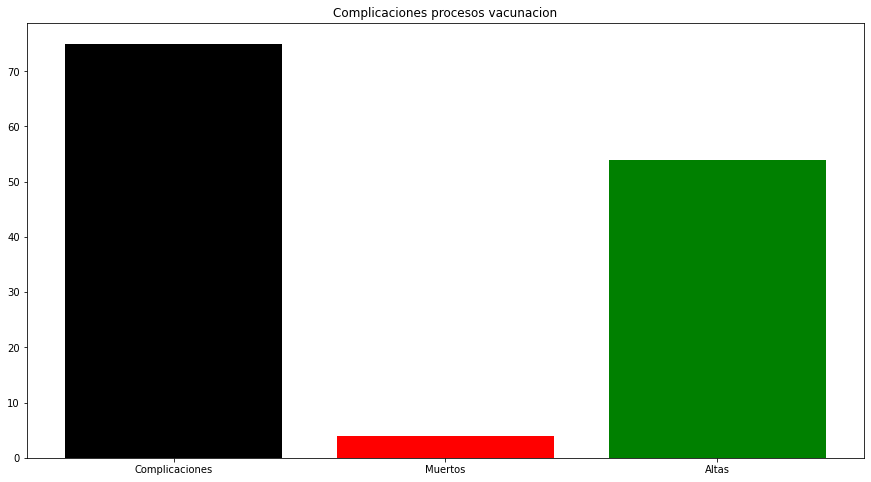

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
#plt.pie([len(personas_complicaciones), len(personas_muertas), len(personas_altas)],colors=['#21F3DC','#4BF218','#F37121'],autopct='%1.1f%%')
#plt.legend(['Complicaciones','Muertos','Altas'],bbox_to_anchor=(0.9, 0, 0.5, 0.9))
resl = [len(personas_complicaciones), len(personas_muertas), len(personas_altas)]
etiquetas = ['Complicaciones','Muertos','Altas']
plt.bar(etiquetas, resl, color=['black', 'red', 'green'])
plt.title('Complicaciones procesos vacunacion')
plt.show()